# Developing Intuition for Fitting Linear Regression Models
A hands-on exploration of linear regression using Python.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This notebook is inspired by Hadley Wickham's "Model Basics" chapter in his excellent "R for Data Science" book. Hadley Wickham is a legend.

This is a Python version that allows me to:

* practice and learn Python
* develop intuition for least squares estimation of linear models

We know about sklearn... we're doing this the long way **on purpose**.

## Let's make up some data
First, let's simulate some data that have a generally linear relationship. These datasets will be meaningless.

We'll use sklearn's `make_regression` function for this. Let's make sure we understand it though.

**`make_regression` explainer**:

```sklearn.datasets.make_regression(n_samples=100, n_features=100, *, n_informative=10, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, shuffle=True, coef=False, random_state=None)```

- `n_samples`: Number of data points to generate
- `n_features`: Number of features (independent variables / predictors). We're doing simple linear regression, so one is all we want for now.
- `noise`: If zero, the points all fall along the line of best fit. That's not much fun to fit, so we want to apply some randomness. Remember the assumptions of linear regression...

> **Assumption of Normality in errors (residuals)**: The residuals (differences between observed and predicted values) should follow a normal distribution when considering multiple predictors together.

So the randomness needs to follow a Gaussian distribution, and the `noise` value tells the function what the standard deviation of that distribution should be.

- `random_state`: This is just so we get the same data every time we run it. This function is generating random data, so if you repeat the process, it's very unlikely you'd get the same output. This setting allows you to fix the randomness to a single state. It's the same as set.seed() in R. Watch this video for a fascinating background on the [generation of pseudorandom numbers](https://youtu.be/GtOt7EBNEwQ?si=hTS00pTn2Kj_bVyQ).


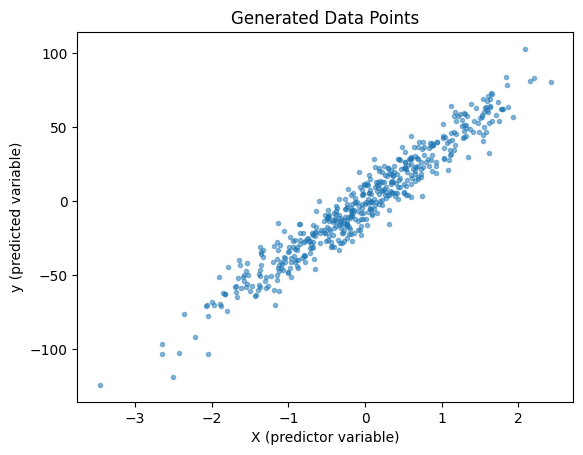

In [ ]:
# Generate simulated data points for linear regression modeling and plot them
from sklearn.datasets import make_regression

# Simulate 500 samples with 1 feature and some noise
X, y = make_regression(n_samples=500, n_features=1, noise=10, random_state=11)

plt.scatter(X, y, alpha=0.5, marker='.')
plt.title("Generated Data Points")
plt.xlabel("X (predictor variable)")
plt.ylabel("y (response variable)")
plt.show()

Next, let's put both columns of data (X and y) into a dataframe.

First, inspect X and y and notice that X is 2D while y is 1D, so we have to handle them differently when assigning them as columns to our df.

If we were running a multiple regression, we would have multiple columns of "X" values ($X_1, X_2, ...$)

## Fun little diversion
Note: Why uppercase X and lowercase y?
Right now, we're doing *simple* linear regression, which uses just one predictor variable, X. But in future, we might want to add multiple predictor variables $X_1, X_2, X_3... X_n$, which means we need to "glue" columns together (like using 4 columns of a spreadsheet instead of 1). A useful way to do this is to use matrices -- so all columns go into a $n \times p$ matrix, that might look like this:

$$
\begin{pmatrix}
  X_1 \\
  X_2 \\
  X_3 \\
  X_n
\end{pmatrix}
$$

In standard mathematical notation, uppercase letters are used for matrices and lowercase letters for vectors. Vectors are just lists of numbers like (1, 2, 3, 4). Matrices are lists of vectors, like ((1, 2, 3), (1, 1, 1), (3, 4, 5)).

So since X is often a matrix, it is uppercase. Since y will always be a vector, it's lowercase.

In [ ]:
# Check the shapes of X and y
X.shape, y.shape

((500, 1), (500,))

In [ ]:
# Create a DataFrame from X and y
# X is 2D, y is 1D

df = pd.DataFrame({
    'X': X[:, 0],
    'y': y,
})
df

,X,y
0,1.727191,67.068871
1,-0.217903,8.198985
2,0.370506,23.928870
3,-0.523088,-21.586658
4,-0.680973,-15.902727
...,...,...
495,-0.788715,-40.924310
496,-0.261961,-10.463544
497,-0.067669,-19.468546
498,0.593498,44.058731


Great. So we have some data and we put it into a dataframe. Now let's imagine that we can't see it—the plot above doesn't exist. How would we fit a line through it? How would we know which line has the best fit?

## Linear Models, but make it CHAOS

Let's start by making a bunch of lines (linear models), and then work out how to tell which one is best.

Let's understand the "space" within which we're working. We can't go beyond the min and max of our data, so let's work out those first.

In [ ]:
# Print the limits of our 2D space
# This helps us understand the range of our data

df_space_limits = df.agg(['min', 'max'], axis=0)
df_space_limits

,X,y
min,-3.460283,-124.034071
max,2.420861,102.848164


Now let's create a series of lines that run straight across that space in different directions.

We know the possible range of X and y values, so let's generate some random pairs of points based on those, and then draw lines through them.

In [ ]:
# Generate random X and Y values using the df_space_limits as limits
num_models = 150

# Set the min and max manually to allow some leeway outside of the real data
xmin = -4
xmax = 4
ymin = -150
ymax = 150

slope_range = 100

# Generate random slopes & intercepts
rng = np.random.default_rng(123)
models = pd.DataFrame({
    "intercepts": rng.uniform(ymin, ymax, num_models),   # intercepts
    "slopes": rng.uniform(-slope_range, slope_range, num_models)         # slopes
})
models.head()

,intercepts,slopes
0,54.705559,-96.941350
1,-133.853694,-30.165263
2,-83.892038,31.862004
3,-94.688457,-46.956774
4,-97.228230,30.403768


Let's see what those models look like on a chart...

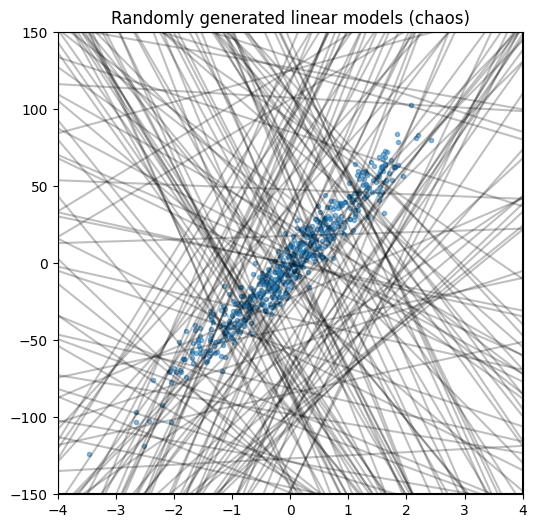

In [ ]:
# Plot all the random models over the data
x_vals = np.linspace(xmin, xmax, 100)

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(X, y, alpha=0.5, marker='.')

# Plot each random model as a line
for _, row in models.iterrows():
    y_vals = row["intercepts"] + row["slopes"] * x_vals  # linear formula
    ax.plot(x_vals, y_vals, color="black", alpha=0.25)

# Draw bounding box
ax.plot([xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        color="black")

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Randomly Generated Linear Models (Chaos)")
plt.show()

There are 150 models on this plot, and a lot are really bad. But a few look ok... maybe? We *could* find the line visually, but remember, we're not doing that... we're still pretending we can't see the data. So how do we tell if these lines are a good fit or not?

One logical first step might be to calculate the vertical distance between each data point and the line. So let's do that for one of our models.

If we're doing the vertical distance from each data point, then we already know $x$, and from the model we know $m$ and $c$, so all we need to do is calculate $y$ for each data point, and compare it to the actual value of $y$.

So let's pick a model randomly, and compare it to each data point. Here, we're calculating the **"residuals"**, which just means "what's left after you take the predicted value away from the actual value."

$$ residuals = y_{actual} - y_{predicted} $$

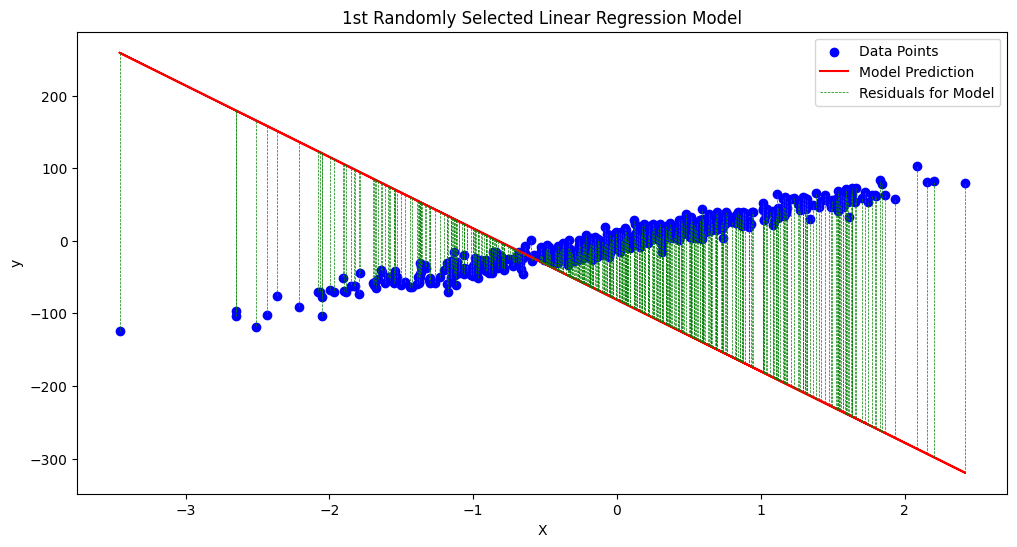

In [ ]:
# Pick a random model and plot its fit and residuals
import random
random.seed(38449)

# Select a random model
rand_mod = random.randint(0, num_models)

# Generate predicted y values for the selected model
# y = intercept + slope * X

df['y_pred'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']

# Calculate residuals
df['residuals1'] = df['y'] - df['y_pred']

# Plot the model line, data points, and residuals
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label='Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title('1st Randomly Selected Linear Regression Model')
plt.legend()
plt.show()

Beautiful! Just kidding... let's try another one.

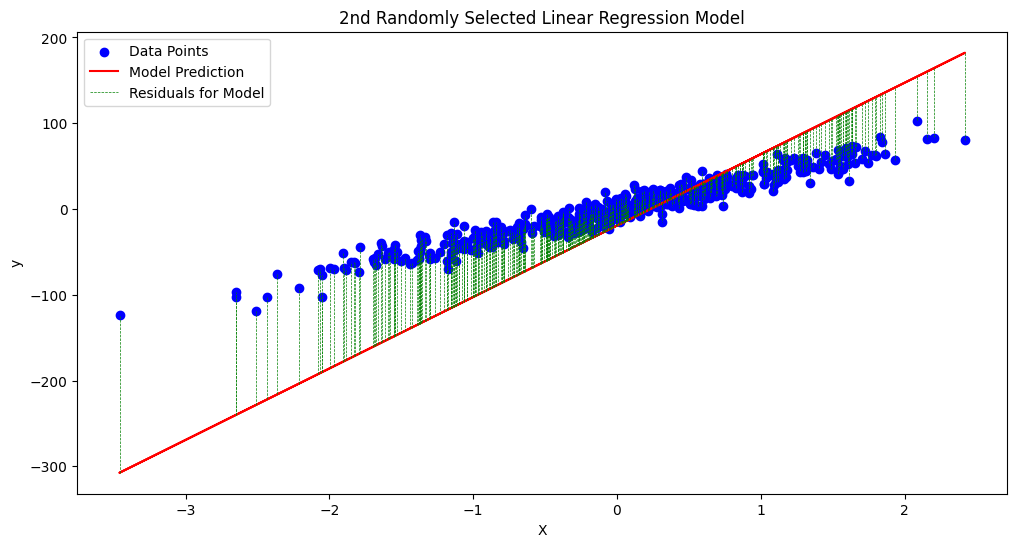

In [ ]:
# Try another random model and plot its fit and residuals
random.seed(45)

rand_mod = random.randint(0, num_models)
df['y_pred2'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']
df['residuals2'] = df['y'] - df['y_pred2']

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred2'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred2'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label='Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title('2nd Randomly Selected Linear Regression Model')
plt.legend()
plt.show()

Bit better... Let's do one more.

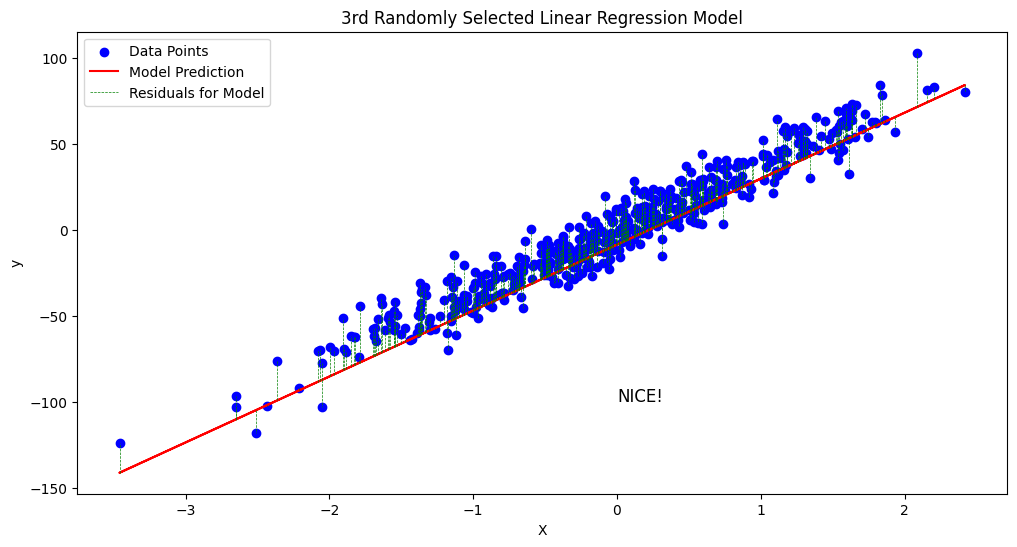

In [ ]:
# Try a third random model and plot its fit and residuals
random.seed(667)

rand_mod = random.randint(0, num_models)
df['y_pred3'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']
df['residuals3'] = df['y'] - df['y_pred3']

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred3'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred3'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label='Residuals for Model')
plt.xlabel('X')
plt.text(0, -100, "NICE!", fontsize=12)
plt.ylabel('y')
plt.title('3rd Randomly Selected Linear Regression Model')
plt.legend()
plt.show()

NICE!

But... I need a way to quantify "NICE!". We can see that less green => better, so let's sum up the "green" (residuals) for each model and compare those.

## Quantifying "NICE!"

In [ ]:
# Compare the count and sum of residuals for each model
# Lower sum means better fit

df[['residuals1', 'residuals2', 'residuals3']].agg(['count', 'sum'], axis=0)

,residuals1,residuals2,residuals3
count,500.000000,500.000000,500.000000
sum,38414.375716,10425.800622,4313.193625


Alright, so:

* Our 1st randomly selected model has a sum of residuals of 38414
* Our 2nd randomly selected model has a sum of residuals of 10426 (lower than 1)
* Our 3rd randomly selected model has a sum of residuals of 4313 (lower than 1 and 2)

So now we have a number that tells us that the 3rd model is better... BUT... what if the data aren't so perfect and we have big outliers? What if we were able to find a model that had huge residuals but because they are positive AND negative, they cancel out?

We need something more robust.

How about the average?

In [ ]:
# Compare the count, sum, and mean of residuals for each model
# Mean can help, but still not robust to outliers

df[['residuals1', 'residuals2', 'residuals3']].agg(['count', 'sum', 'mean'], axis=0)

,residuals1,residuals2,residuals3
count,500.000000,500.000000,500.000000
sum,38414.375716,10425.800622,4313.193625
mean,76.828751,20.851601,8.626387


Well, that actually makes it harder to tell the difference between the models. I think we can all agree that model 1 is the worst, but the difference between model 1 and model 3 is only 68 points, not a lot.

## Be there or be square

So, this is where a little math background comes in... If we multiply each residual by itself (square it), then the bigger numbers get MUCH bigger, while the smaller numbers stay REAL SMALL. We also make negative numbers positive, which means that averaging them won't cause positive and negative differences to cancel out.

Watch...

In [ ]:
# Square the residuals then sum them (and other useful aggregations)
df[['residuals1', 'residuals2', 'residuals3']].pow(2).agg(['count', 'sum', 'mean', 'std'], axis=0)

,residuals1,residuals2,residuals3
count,5.000000e+02,5.000000e+02,500.000000
sum,1.176542e+07,1.290983e+06,83422.099543
mean,2.353085e+04,2.581966e+03,166.844199
std,2.966120e+04,3.718513e+03,208.604995


Ok great -- now we can see fairly clearly that model 3 is best.

So, now let's apply this logic to ALL the models and see which of our models is best.

In [ ]:
# Preview the first few models
models.head()

,intercepts,slopes
0,54.705559,-96.941350
1,-133.853694,-30.165263
2,-83.892038,31.862004
3,-94.688457,-46.956774
4,-97.228230,30.403768


In [ ]:
# Revert our df back to the original
# This ensures we don't have extra columns from previous steps
df = pd.DataFrame({
    'X': X[:, 0],
    'y': y,
})

# Function to apply the squared error (residuals) calculation to every model in the list
def model_sse(row):
    y_pred = row['intercepts'] + row['slopes'] * df['X']
    residuals = df['y'] - y_pred
    sse = (residuals ** 2).sum()
    return pd.Series({
        'intercept': row['intercepts'],
        'slope': row['slopes'],
        'sse': sse,
        'mse': sse / len(df),  # mean squared error
        'rmse': np.sqrt(sse / len(df))  # root mean squared error
    })

# Apply it to all models in the list
results = models.apply(model_sse, axis=1).reset_index(names='model_id')
results.head()

,model_id,intercept,slope,sse,mse,rmse
0,0,54.705559,-96.941350,1.037811e+07,20756.214664,144.070173
1,1,-133.853694,-30.165263,1.085433e+07,21708.661457,147.338595
2,2,-83.892038,31.862004,3.555813e+06,7111.626178,84.330458
3,3,-94.688457,-46.956774,7.631472e+06,15262.944563,123.543290
4,4,-97.228230,30.403768,4.763668e+06,9527.335105,97.608069


So... which is the best model out of our 150 random models? All we need to do is take the model with the smallest SSE (or RMSE).

In [ ]:
# Find the best model (min SSE)
best_model = results.nsmallest(1, 'sse')
best_model

,model_id,intercept,slope,sse,mse,rmse
83,83,-3.003589,39.348855,52623.236154,105.246472,10.25897


Let's plot that model and see how it looks.

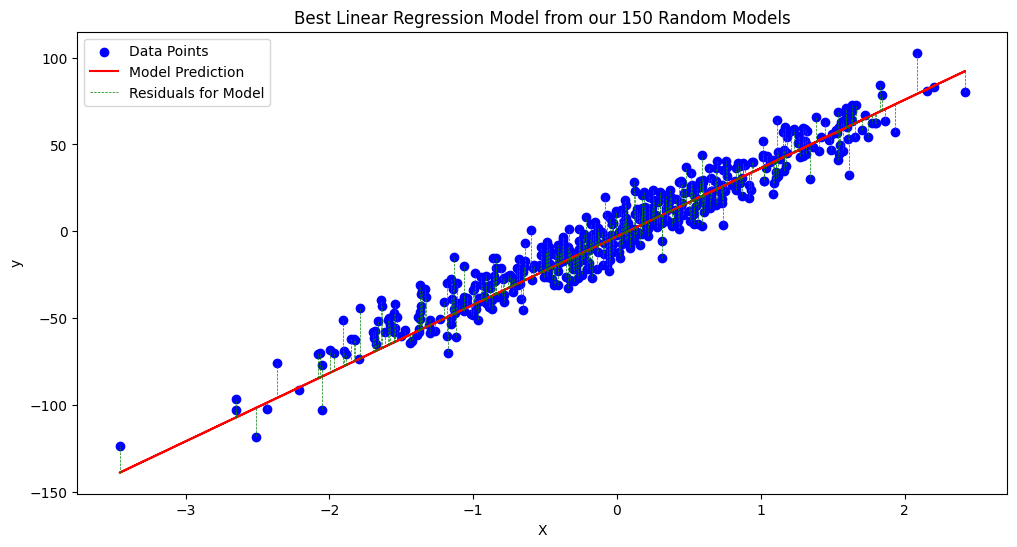

In [ ]:
# Plot the best model from our random models
rand_mod = best_model['model_id'].values[0]
df['y_pred'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']
df['residuals1'] = df['y'] - df['y_pred']

plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label='Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Best Linear Regression Model from our 150 Random Models')
plt.legend()
plt.show()

Here's a chart showing all of the models by fit, according to their slopes and intercepts.

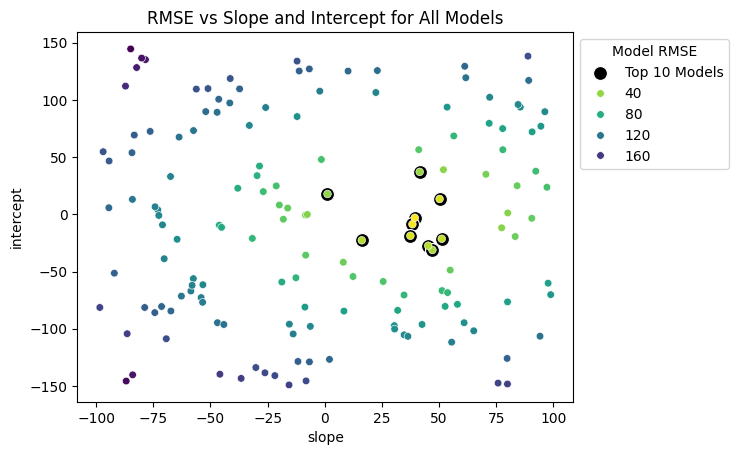

In [ ]:
# Visualize RMSE vs slope and intercept for all models
top_10_mods = results.nsmallest(10, 'rmse')

sns.scatterplot(data=top_10_mods, x='slope', y='intercept', color='black', s=100, label='Top 10 Models')
sns.scatterplot(data=results, x='slope', y='intercept', s=30, hue='rmse', palette='viridis_r')
plt.title('RMSE vs Slope and Intercept for All Models')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Model RMSE")
plt.show()

## But be organized about it

So until now we've been using randomly generated models. But we could be more systematic and use a method called grid search. This is where we generate a grid of evenly spaced models and then run the same distance measures. Here I picked slopes and intercepts based on the best models shown in the chart above...

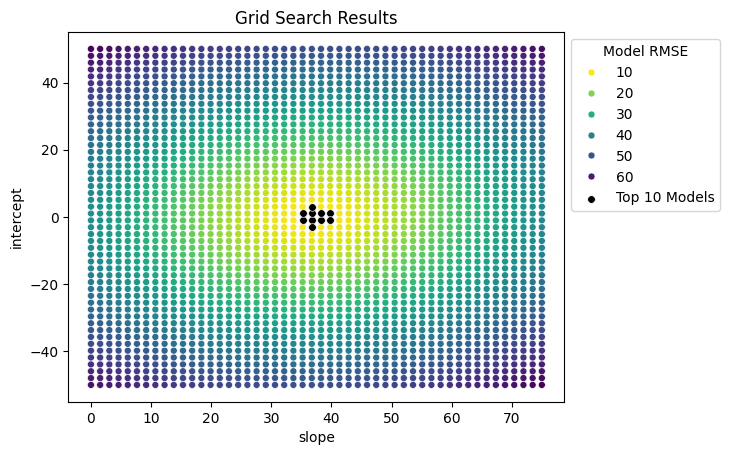

In [ ]:
# Grid search for best model
# Reminder of the function
def model_sse(row):
    y_pred = row['intercepts'] + row['slopes'] * df['X']
    residuals = df['y'] - y_pred
    sse = (residuals ** 2).sum()
    return pd.Series({
        'intercept': row['intercepts'],
        'slope': row['slopes'],
        'sse': sse,
        'mse': sse / len(df),  # mean squared error
        'rmse': np.sqrt(sse / len(df))  # root mean squared error
    })

# Make the grid
slopes = pd.DataFrame({"slopes": np.linspace(0, 75, 50)})
intercepts = pd.DataFrame({"intercepts": np.linspace(-50, 50, 50)})
grid = slopes.merge(intercepts, how="cross")

# Apply the fit to each model in the grid
grid_results = grid.apply(model_sse, axis=1).reset_index(names='model_id')
top_10_grid_results = grid_results.nsmallest(10, 'rmse')

sns.scatterplot(data=grid_results, x='slope', y='intercept', s=25, hue='rmse', palette='viridis_r')
sns.scatterplot(data=top_10_grid_results, x='slope', y='intercept', color='black', s=30, label='Top 10 Models')
plt.title('Grid Search Results')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Model RMSE")
plt.show()

Pretty nice! So theoretically we could keep iterating on this grid search process to get the best model, BUT... would it be the BEST POSSIBLE model? Probably not.

## Optimally yours

In his R book, Hadley Wickham makes use of the Newton-Raphson search tool, which is a numerical minimization tool. It picks a starting point and then looks around for the steepest slope (similar to, but not, gradient descent). Hadley uses `optim()` to run that. A little googling tells me that `scipy.optimize.minimize` is the equivalent. Let's play...

In [ ]:
from scipy.optimize import minimize

# Revert our df back to the original
df = pd.DataFrame({
    'X': X[:, 0],
    'y': y,
})

# Edit the function so that we just get a single value back
def model_rmse(params, X, y):
    intercept, slope = params
    y_pred = intercept + slope * X
    residuals = y - y_pred
    rmse = np.sqrt(np.mean(residuals ** 2))
    return rmse

# Apply the optimization function
initial_guess = [0, 0]  # initial guess for intercept and slope
result = minimize(model_rmse, initial_guess, args=(df['X'], df['y']))

# Extract the optimized parameters
optimized_intercept, optimized_slope = result.x

In [ ]:
# Print the optimal model parameters found by Newton-Raphson
print(f"Our optimal model was found to have intercept: {optimized_intercept:.4f}, and slope: {optimized_slope:.4f}")

Our optimal model was found to have intercept: -0.07967232585388516, and slope: 36.9187345299132


Let's plot the optimal model.

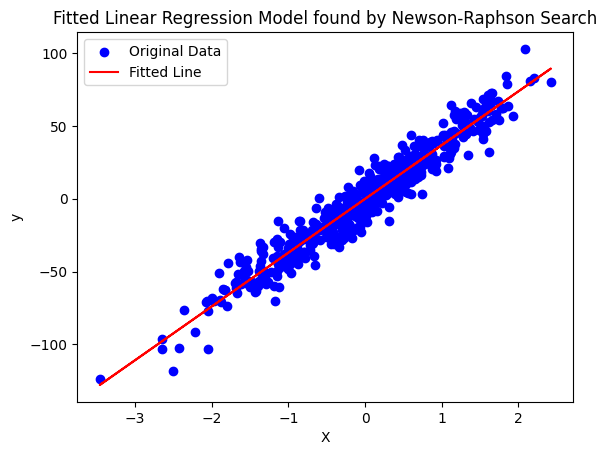

In [ ]:
# Plot the optimal model against the original X and y data
plt.scatter(df['X'], df['y'], color='blue', label='Original Data')
plt.plot(df['X'], optimized_intercept + optimized_slope * df['X'], color='red', label='Fitted Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Fitted Linear Regression Model found by Newton-Raphson Search')
plt.legend()
plt.show()

## Now do all that in a few lines of code

Now let's do this using sklearn's LinearRegression tool and see how we did...

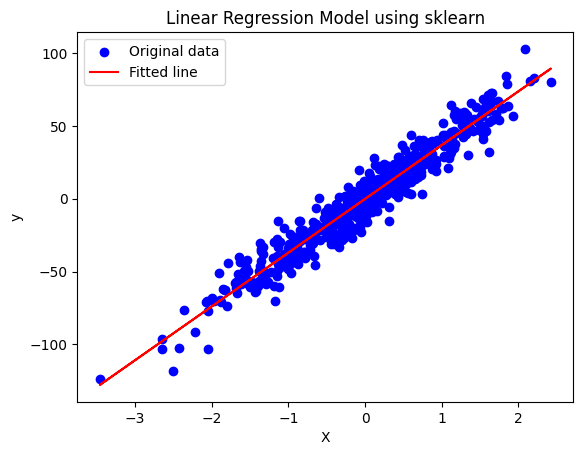

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a linear regression model
lm = LinearRegression()

# Fit the model
lm.fit(X, y)

# Make predictions
y_pred = lm.predict(X)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Plot the model against the original data
plt.scatter(X, y, color='blue', label='Original data')
plt.plot(X, y_pred, color='red', label='Fitted line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Model using sklearn')
plt.legend()
plt.show()

## We had fun, didn't we?

In [ ]:
# Compare intercept and slope values from different methods

grid_search_intercept = top_10_grid_results.nsmallest(1, 'rmse')['intercept'].values[0]
grid_search_slope = top_10_grid_results.nsmallest(1, 'rmse')['slope'].values[0]

print(f"Our optimal model using coarse grid search was found to have:   intercept: {grid_search_intercept:.4f}, and slope: {grid_search_slope:.2f}")
print(f"Our optimal model using Newton-Raphson was found to have:       intercept: {optimized_intercept:.4f}, and slope: {optimized_slope:.2f}")
print(f"Our optimal model using sklearn was found to have:              intercept: {lm.intercept_:.4f}, and slope: {lm.coef_[0]:.2f}")

Our optimal model using coarse grid search was found to have:   intercept: -1.0204, and slope: 36.73
Our optimal model using Newson-Raphson was found to have:       intercept: -0.0797, and slope: 36.92
Our optimal model using sklearn was found to have:              intercept: -0.0797, and slope: 36.92
